<a href="https://colab.research.google.com/github/kkamal11/Capstone-Project-Business-data-management/blob/main/BDM_CAPSTONE_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install squarify

In [2]:
import os
import json

#Data processing and manipulation imports
import numpy as np
import pandas as pd

#Visualization specific imports
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.patches import Patch
import squarify

#Product Affinity Analysis import
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#sklearn specific imports
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import warnings

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def list_files(folder_path):
    files = {}
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            files[filename[:-4]] = file_path
    return files

dataset_files = list_files('/content/drive/MyDrive/bdm_dataset')
print(json.dumps(dataset_files, indent=4))

{
    "payments": "/content/drive/MyDrive/bdm_dataset/payments.csv",
    "customers": "/content/drive/MyDrive/bdm_dataset/customers.csv",
    "sellers": "/content/drive/MyDrive/bdm_dataset/sellers.csv",
    "products": "/content/drive/MyDrive/bdm_dataset/products.csv",
    "order_items": "/content/drive/MyDrive/bdm_dataset/order_items.csv",
    "orders": "/content/drive/MyDrive/bdm_dataset/orders.csv",
    "geolocation": "/content/drive/MyDrive/bdm_dataset/geolocation.csv"
}


In [6]:
customers = pd.read_csv(dataset_files['customers'])
orders = pd.read_csv(dataset_files['orders'])
products = pd.read_csv(dataset_files['products'])
order_items = pd.read_csv(dataset_files['order_items'])
sellers = pd.read_csv(dataset_files['sellers'])
geolocation = pd.read_csv(dataset_files['geolocation'])
payments = pd.read_csv(dataset_files['payments'])

In [7]:
DATE_FORMAT = '%d-%m-%Y %H:%M'
DECIMAL_PLACES = 3

#### Meta Data and Descriptive Statistics

In [8]:
customers.shape, orders.shape, order_items.shape

((99441, 5), (99441, 8), (112650, 7))

In [9]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [10]:
customers.describe(include='object')

,customer_id,customer_unique_id,customer_city,customer_state
count,99441,99441,99441,99441
unique,99441,96096,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP
freq,1,17,15540,41746


In [11]:
customers[['customer_id', 'customer_unique_id']].nunique()

,0
customer_id,99441
customer_unique_id,96096


In [12]:
orders.isna().sum()

,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,160
order_delivered_carrier_date,1783
order_delivered_customer_date,2965
order_estimated_delivery_date,0


In [13]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,02-10-2017 10:56,02-10-2017 11:07,04-10-2017 19:55,10-10-2017 21:25,18-10-2017 00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,24-07-2018 20:41,26-07-2018 03:24,26-07-2018 14:31,07-08-2018 15:27,13-08-2018 00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,08-08-2018 08:38,08-08-2018 08:55,08-08-2018 13:50,17-08-2018 18:06,04-09-2018 00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,18-11-2017 19:28,18-11-2017 19:45,22-11-2017 13:39,02-12-2017 00:28,15-12-2017 00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,13-02-2018 21:18,13-02-2018 22:20,14-02-2018 19:46,16-02-2018 18:17,26-02-2018 00:00


In [14]:
orders.describe(include='all')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,88789,50462,61544,75649,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,02-08-2018 12:06,10-01-2018 10:32,09-05-2018 15:48,01-02-2018 20:29,20-12-2017 00:00
freq,1,1,96478,28,109,47,7,522


In [15]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,19-09-2017 09:45,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,03-05-2017 11:05,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,18-01-2018 14:48,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,15-08-2018 10:10,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,13-02-2017 13:57,199.90,18.14


In [16]:
order_items.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
order_id,112650,98666,8272b63d03f5f79c56e9e4120aec44ef,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_item_id,112650.0,NaN,NaN,NaN,1.197834,0.705124,1.0,1.0,1.0,1.0,21.0
product_id,112650,32951,aca2eb7d00ea1a7b8ebd4e68314663af,527,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller_id,112650,3095,6560211a19b47992c3666cc44a7e94c0,2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shipping_limit_date,112650,54615,27-02-2018 03:31,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,112650.0,NaN,NaN,NaN,120.653739,183.633928,0.85,39.9,74.99,134.9,6735.0
freight_value,112650.0,NaN,NaN,NaN,19.99032,15.806405,0.0,13.08,16.26,21.15,409.68


In [17]:
order_items['price'].sum() #total revenue

13591643.700000003

In [18]:
products.head()

,product_id,product category,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,Art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sport leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,babies,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [19]:
products.describe(include='object').T

,count,unique,top,freq
product_id,32951,32951,1e9e8ef04dbcff4541ed26657ea517e5,1
product category,32341,73,bed table bath,3029


In [20]:
sellers.head(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


In [21]:
sellers.describe(include='object').T

,count,unique,top,freq
seller_id,3095,3095,3442f8959a84dea7ee197c632cb2df15,1
seller_city,3095,611,sao paulo,694
seller_state,3095,23,SP,1849


In [22]:
geolocation.head(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP


In [23]:
geolocation.describe(include='object').T

,count,unique,top,freq
geolocation_city,1000163,8011,sao paulo,135800
geolocation_state,1000163,27,SP,404268


In [24]:
payments.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


In [25]:
payments.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
order_id,103886,99440,fa65dad1b0e818e3ccc5cb0e39231352,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_sequential,103886.0,NaN,NaN,NaN,1.092679,0.706584,1.0,1.0,1.0,1.0,29.0
payment_type,103886,5,credit_card,76795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_installments,103886.0,NaN,NaN,NaN,2.853349,2.687051,0.0,1.0,1.0,4.0,24.0
payment_value,103886.0,NaN,NaN,NaN,154.10038,217.494064,0.0,56.79,100.0,171.8375,13664.08


In [26]:
orders_df = orders.copy()
geolocation_df = geolocation.copy().drop_duplicates(subset=['geolocation_zip_code_prefix'])
order_items_df = order_items.copy().drop_duplicates(subset=['order_id'])
payments_df = payments.copy().drop_duplicates(subset=['order_id'])
print(geolocation_df.shape, order_items_df.shape)

(19015, 5) (98666, 7)


In [27]:
cust_order_df_ = pd.merge(customers, orders_df, on='customer_id', how='inner')
cust_order_items_df_ = pd.merge(cust_order_df_, order_items_df, on='order_id', how='inner')
cust_order_items_payment_df_ = pd.merge(cust_order_items_df_, payments_df, on='order_id', how='left')
cust_order_items_payment_geolocation_df_ = pd.merge(cust_order_items_payment_df_, geolocation_df, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
cust_order_items_payment_geolocation_seller_df = pd.merge(cust_order_items_payment_geolocation_df_, sellers,on='seller_id', how='left')
print(cust_order_items_payment_geolocation_seller_df.shape)
cust_order_items_payment_geolocation_seller_df.head()

(98666, 30)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,16-05-2017 15:05,16-05-2017 15:22,23-05-2017 10:47,25-05-2017 10:35,05-06-2017 00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,22-05-2017 15:22,124.99,21.88,1.0,credit_card,2.0,146.87,14409.0,-20.509898,-47.397866,franca,SP,8577,itaquaquecetuba,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,12-01-2018 20:48,12-01-2018 20:58,15-01-2018 17:14,29-01-2018 12:41,06-02-2018 00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,18-01-2018 20:58,289.00,46.48,1.0,credit_card,8.0,335.48,9790.0,-23.726853,-46.545746,sao bernardo do campo,SP,88303,itajai,SC
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,19-05-2018 16:07,20-05-2018 16:19,11-06-2018 14:31,14-06-2018 17:58,13-06-2018 00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,05-06-2018 16:19,139.94,17.79,1.0,credit_card,7.0,157.73,1151.0,-23.527788,-46.660310,sao paulo,SP,8577,itaquaquecetuba,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,13-03-2018 16:06,13-03-2018 17:29,27-03-2018 23:22,28-03-2018 16:04,10-04-2018 00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,27-03-2018 16:31,149.94,23.36,1.0,credit_card,1.0,173.30,8775.0,-23.496930,-46.185352,mogi das cruzes,SP,8577,itaquaquecetuba,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,29-07-2018 09:51,29-07-2018 10:10,30-07-2018 15:16,09-08-2018 20:55,15-08-2018 00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,31-07-2018 10:10,230.00,22.25,1.0,credit_card,8.0,252.25,13056.0,-22.987222,-47.151073,campinas,SP,14940,ibitinga,SP


---

# **Delivery Analysis**

In [28]:
print(f"Total orders placed: {orders['order_id'].shape[0]}")

Total orders placed: 99441


#### Distribution Of Order By Status

In [29]:
order_status_count = orders_df.groupby('order_status').agg({
    'order_id': 'count',
}).reset_index()

order_status_count.columns = ['order_status', 'Order count']
order_status_count['Percentage'] = round(order_status_count['Order count'] / order_status_count['Order count'].sum() * 100, 3)
order_status_count.T.to_csv('order_status_count.csv', index=True)
order_status_count.T

,0,1,2,3,4,5,6,7
order_status,approved,canceled,created,delivered,invoiced,processing,shipped,unavailable
Order count,2,625,5,96478,314,301,1107,609
Percentage,0.002,0.629,0.005,97.02,0.316,0.303,1.113,0.612


#### Distribution Of orders by state

In [30]:
customer_state_order_counts = cust_order_items_payment_geolocation_seller_df.groupby('customer_state').agg(
    {'order_id': 'nunique',
     'seller_id':'nunique',
     'customer_zip_code_prefix':'nunique',
     'seller_zip_code_prefix':'nunique',
     'customer_unique_id':'nunique'
    }
    ).reset_index()

# Rename the columns for clarity
customer_state_order_counts.columns = [
    'customer_state', 'number_of_orders', 'number_of_sellers','number_of_customer_zip_codes','number_of_seller_zip_codes',
    'number_of_customers']

customer_state_order_counts.sort_values(by=['number_of_orders'], inplace=True, ascending=False)
customer_state_order_counts.head()

,customer_state,number_of_orders,number_of_sellers,number_of_customer_zip_codes,number_of_seller_zip_codes,number_of_customers
25,SP,41375,2543,5584,1922,39981
18,RJ,12762,1743,1198,1381,12303
10,MG,11544,1654,1348,1319,11178
22,RS,5432,1221,875,1013,5249
17,PR,4998,1226,859,1015,4840


In [31]:
fig = px.bar(customer_state_order_counts, x='customer_state', y='number_of_orders',
             labels={'customer_state': 'Customer State', 'number_of_orders': 'Number of Orders'},
             title='Number of Orders per Customer State',
             text_auto=True
            )

fig.show()

In [32]:
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'], format=DATE_FORMAT)
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'], format=DATE_FORMAT)
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'], format=DATE_FORMAT)
orders_df['order_approved_at_date'] = pd.to_datetime(orders_df['order_approved_at'], format=DATE_FORMAT)

# time difference
orders_df['time_taken_to_deliver'] = orders_df['order_delivered_customer_date'] - orders_df['order_purchase_timestamp']
orders_df['estimated_time_to_deliver'] = orders_df['order_estimated_delivery_date'] - orders_df['order_purchase_timestamp']
orders_df['time_taken_to_approve'] = orders_df['order_approved_at_date'] - orders_df['order_purchase_timestamp']

orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_approved_at_date,time_taken_to_deliver,estimated_time_to_deliver,time_taken_to_approve
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,02-10-2017 11:07,04-10-2017 19:55,2017-10-10 21:25:00,2017-10-18,2017-10-02 11:07:00,8 days 10:29:00,15 days 13:04:00,0 days 00:11:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:00,26-07-2018 03:24,26-07-2018 14:31,2018-08-07 15:27:00,2018-08-13,2018-07-26 03:24:00,13 days 18:46:00,19 days 03:19:00,1 days 06:43:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:00,08-08-2018 08:55,08-08-2018 13:50,2018-08-17 18:06:00,2018-09-04,2018-08-08 08:55:00,9 days 09:28:00,26 days 15:22:00,0 days 00:17:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:00,18-11-2017 19:45,22-11-2017 13:39,2017-12-02 00:28:00,2017-12-15,2017-11-18 19:45:00,13 days 05:00:00,26 days 04:32:00,0 days 00:17:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:00,13-02-2018 22:20,14-02-2018 19:46,2018-02-16 18:17:00,2018-02-26,2018-02-13 22:20:00,2 days 20:59:00,12 days 02:42:00,0 days 01:02:00


In [33]:
orders_df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
time_taken_to_deliver,96476,12 days 13:24:28.129275674,9 days 13:07:00.408435733,0 days 12:48:00,6 days 18:23:45,10 days 05:14:00,15 days 17:17:00,209 days 15:05:00
estimated_time_to_deliver,99441,23 days 18:25:54.473708028,8 days 19:58:36.917204223,1 days 15:35:00,18 days 07:58:00,23 days 05:47:00,28 days 10:12:00,155 days 03:16:00
time_taken_to_approve,99281,0 days 10:25:11.665071866,1 days 02:02:15.997999785,0 days 00:00:00,0 days 00:13:00,0 days 00:21:00,0 days 14:35:00,187 days 21:11:00


#### Analysis of actual vs estimated delivery time

In [34]:
avg_delivery_time = orders_df[orders_df['order_status'] == 'delivered']['time_taken_to_deliver'].mean()
avg_estimated_delivery_time = orders_df[orders_df['order_status'] == 'delivered']['estimated_time_to_deliver'].mean()
avg_time_to_approve = orders_df[orders_df['order_status'] == 'delivered']['time_taken_to_approve'].mean()

act_est_time_df = pd.DataFrame({
    'Average Actual Delivery Time': [avg_delivery_time],
    'Average Estimated Delivery Time': [avg_estimated_delivery_time],
    'Average Time Taken To Approve': [avg_time_to_approve]
})
act_est_time_df.T

,0
Average Actual Delivery Time,12 days 13:23:46.206903700
Average Estimated Delivery Time,23 days 17:40:49.936980452
Average Time Taken To Approve,0 days 10:16:39.306269696


In [35]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=['Average Actual Delivery Time', 'Average Estimated Delivery Time'],
    y=[act_est_time_df['Average Actual Delivery Time'].iloc[0].days, act_est_time_df['Average Estimated Delivery Time'].iloc[0].days],
    text=[act_est_time_df['Average Actual Delivery Time'].iloc[0].days, act_est_time_df['Average Estimated Delivery Time'].iloc[0].days],
    textposition='inside',
    width=0.25, # Adjust width for thinner bars
    marker_color=['blue', 'red'],
    name='Delivery Time'
))

fig.update_layout(
    title='Comparison of Average Actual vs Estimated Delivery Time',
    xaxis_title='Delivery Time',
    yaxis_title='Time (Days)',
    yaxis_range=[0, max(act_est_time_df['Average Actual Delivery Time'].iloc[0].days, act_est_time_df['Average Estimated Delivery Time'].iloc[0].days) + 1], # Set appropriate y-axis range
    barmode='group'
)

fig.show()

#### Correlation Analysis: Number of Orders vs Number of Sellers

In [36]:
correlation_coefficient = customer_state_order_counts['number_of_orders'].corr(customer_state_order_counts['number_of_sellers'])

# Create the scatter plot with a trendline
fig = px.scatter(customer_state_order_counts,
                 x='number_of_orders',
                 y='number_of_sellers',
                 trendline="ols",  # Add Ordinary Least Squares trendline
                 title=f'Correlation between Number of Orders and Number of Sellers (r = {correlation_coefficient:.2f})',
                 labels={'number_of_orders': 'Number of Orders', 'number_of_sellers': 'Number of Sellers'})

fig.show()

#### Delayed Orders Analysis

In [37]:
# orders_df[orders_df['time_taken_to_deliver'] > orders_df['estimated_time_to_deliver']].shape
late_delivered_order_count = orders_df[
    (orders_df['order_status'] == 'delivered') & (orders_df['time_taken_to_deliver'] > orders_df['estimated_time_to_deliver'])
].shape[0]
delivered_order_count = orders_df[orders_df['order_status'] == 'delivered'].shape[0]
print(f"Total delivered orders: {delivered_order_count}")
print(f"Total late delivered orders: {late_delivered_order_count}")
print(f"late delivered order percentage: {(late_delivered_order_count/delivered_order_count) * 100 :.2f}%")

Total delivered orders: 96478
Total late delivered orders: 7826
late delivered order percentage: 8.11%


In [38]:
late_delivered_order_df = orders_df[(orders_df['order_status'] == 'delivered') & (orders_df['time_taken_to_deliver'] > orders_df['estimated_time_to_deliver'])]
print(f"Total orders delivered late {late_delivered_order_df.shape[0]}")
late_delivered_order_df.head(3)

Total orders delivered late 7826


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_approved_at_date,time_taken_to_deliver,estimated_time_to_deliver,time_taken_to_approve
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,delivered,2017-09-18 14:31:00,19-09-2017 04:04,06-10-2017 17:50,2017-10-09 22:23:00,2017-09-28,2017-09-19 04:04:00,21 days 07:52:00,9 days 09:29:00,0 days 13:33:00
25,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,delivered,2018-02-20 23:46:00,22-02-2018 02:30,26-02-2018 22:25,2018-03-21 22:03:00,2018-03-12,2018-02-22 02:30:00,28 days 22:17:00,19 days 00:14:00,1 days 02:44:00
35,8563039e855156e48fccee4d611a3196,5f16605299d698660e0606f7eae2d2f9,delivered,2018-02-17 15:59:00,17-02-2018 16:15,20-02-2018 23:03,2018-03-20 00:59:00,2018-03-20,2018-02-17 16:15:00,30 days 09:00:00,30 days 08:01:00,0 days 00:16:00


In [39]:
merged_df = pd.merge(customers, late_delivered_order_df, on='customer_id', how='inner')
merged_df = pd.merge(merged_df, order_items_df, on='order_id', how='inner')
merged_df = pd.merge(merged_df, payments_df, on='order_id', how='left')
merged_df = pd.merge(merged_df, geolocation_df, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
merged_df = pd.merge(merged_df, sellers,on='seller_id', how='inner')

delivery_time_analysis_df = merged_df.copy()

print(merged_df.shape)
delivery_time_analysis_df.head()

(7826, 34)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_approved_at_date,time_taken_to_deliver,estimated_time_to_deliver,time_taken_to_approve,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,seller_zip_code_prefix,seller_city,seller_state
0,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:00,20-05-2018 16:19,11-06-2018 14:31,2018-06-14 17:58:00,2018-06-13,2018-05-20 16:19:00,26 days 01:51:00,24 days 07:53:00,1 days 00:12:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,05-06-2018 16:19,139.94,17.79,1.0,credit_card,7.0,157.73,1151.0,-23.527788,-46.660310,sao paulo,SP,8577,itaquaquecetuba,SP
1,9b8ce803689b3562defaad4613ef426f,7f3a72e8f988c6e735ba118d54f47458,5416,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:00,13-05-2017 11:55,15-05-2017 15:30,2017-06-07 12:02:00,2017-05-30,2017-05-13 11:55:00,26 days 22:14:00,18 days 10:12:00,1 days 22:07:00,1,99a4788cb24856965c36a24e339b6058,4a3ca9315b744ce9f8e9374361493884,19-05-2017 11:55,89.90,12.13,2.0,voucher,1.0,34.05,5416.0,-23.555015,-46.692274,sao paulo,SP,14940,ibitinga,SP
2,b2bed119388167a954382cca36c4777f,e079b18794454de9d2be5c12b4392294,27525,resende,RJ,77b062be7c5bd21712905feb8e1cfeed,delivered,2017-06-14 18:31:00,15-06-2017 18:43,22-06-2017 08:11,2017-07-07 20:32:00,2017-07-07,2017-06-15 18:43:00,23 days 02:01:00,22 days 05:29:00,1 days 00:12:00,1,6421588f55f75de28cb3357e07723d14,1900267e848ceeba8fa32d80c1a5f5a8,21-06-2017 18:43,56.99,16.13,1.0,credit_card,8.0,134.25,27525.0,-22.478051,-44.506081,resende,RJ,14940,ibitinga,SP
3,a905baa530258422594f1b05615bd225,c80da60feddb7cf8325bd104032e314a,60140,fortaleza,CE,4f0695330f3816ef294bf1f4b18f4f2e,delivered,2018-03-29 21:28:00,29-03-2018 21:35,12-04-2018 23:36,2018-05-08 16:52:00,2018-04-23,2018-03-29 21:35:00,39 days 19:24:00,24 days 02:32:00,0 days 00:07:00,1,3fbc0ef745950c7932d5f2a446189725,06a2c3af7b3aee5d69171b0e14f0ee87,04-04-2018 21:35,61.99,15.31,1.0,credit_card,1.0,77.30,60140.0,-3.741678,-38.494779,fortaleza,CE,65072,sao luis,MA
4,6bed27564bd99d78d09c1fac13da56fd,463093247faa080167d77f2e6d1b297d,13321,salto,SP,0e5d9583490deb1e011b1c8e7da13398,delivered,2018-03-22 12:07:00,22-03-2018 12:15,27-03-2018 22:12,2018-05-09 19:48:00,2018-04-11,2018-03-22 12:15:00,48 days 07:41:00,19 days 11:53:00,0 days 00:08:00,1,9d014ce7c9f42f5d675f893d6abf1339,46dc3b2cc0980fb8ec44634e21d2718e,28-03-2018 12:15,299.99,28.18,1.0,credit_card,4.0,328.17,13321.0,-23.190244,-47.291571,salto,SP,22240,rio de janeiro,RJ


#### Late Delivered Orders: Comparison of Same Zip Code vs. Different Zip Code Deliveries

In [40]:
d = {
    'with_same_customer_seller_zip_code': delivery_time_analysis_df[delivery_time_analysis_df['customer_zip_code_prefix'] == delivery_time_analysis_df['seller_zip_code_prefix']]['order_id'].nunique(),
    'with_different_customer_seller_zip_code': delivery_time_analysis_df[delivery_time_analysis_df['customer_zip_code_prefix'] != delivery_time_analysis_df['seller_zip_code_prefix']]['order_id'].nunique()
}
pd.DataFrame(d, index=['late_delivered_order_count']).T

,late_delivered_order_count
with_same_customer_seller_zip_code,2
with_different_customer_seller_zip_code,7824


In [41]:
mean_delivery_time_for_delayed_orders = delivery_time_analysis_df['time_taken_to_deliver'].mean()
print(f"mean_delivery_time_for_delayed_orders: {mean_delivery_time_for_delayed_orders}")  #much greater than actual delivery time 12 days

mean_delivery_time_for_delayed_orders: 31 days 12:27:07.927421416


In [42]:
late_order_product_df = pd.merge(delivery_time_analysis_df, products, left_on='product_id', right_on='product_id', how='left')

req_cols = ['customer_id', 'customer_unique_id','customer_zip_code_prefix','customer_city','customer_state','order_id',
     'order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date',
     'order_estimated_delivery_date','time_taken_to_deliver','time_taken_to_approve','seller_id','shipping_limit_date','seller_zip_code_prefix','product category'
]
req_df = late_order_product_df[req_cols]
print(late_order_product_df.shape, req_df.shape)
req_df.head()

(7826, 42) (7826, 17)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,time_taken_to_deliver,time_taken_to_approve,seller_id,shipping_limit_date,seller_zip_code_prefix,product category
0,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:00,20-05-2018 16:19,11-06-2018 14:31,2018-06-14 17:58:00,2018-06-13,26 days 01:51:00,1 days 00:12:00,7c67e1448b00f6e969d365cea6b010ab,05-06-2018 16:19,8577,Furniture office
1,9b8ce803689b3562defaad4613ef426f,7f3a72e8f988c6e735ba118d54f47458,5416,sao paulo,SP,17825f24877a9289214c301ae0c9424b,2017-05-11 13:48:00,13-05-2017 11:55,15-05-2017 15:30,2017-06-07 12:02:00,2017-05-30,26 days 22:14:00,1 days 22:07:00,4a3ca9315b744ce9f8e9374361493884,19-05-2017 11:55,14940,bed table bath
2,b2bed119388167a954382cca36c4777f,e079b18794454de9d2be5c12b4392294,27525,resende,RJ,77b062be7c5bd21712905feb8e1cfeed,2017-06-14 18:31:00,15-06-2017 18:43,22-06-2017 08:11,2017-07-07 20:32:00,2017-07-07,23 days 02:01:00,1 days 00:12:00,1900267e848ceeba8fa32d80c1a5f5a8,21-06-2017 18:43,14940,bed table bath
3,a905baa530258422594f1b05615bd225,c80da60feddb7cf8325bd104032e314a,60140,fortaleza,CE,4f0695330f3816ef294bf1f4b18f4f2e,2018-03-29 21:28:00,29-03-2018 21:35,12-04-2018 23:36,2018-05-08 16:52:00,2018-04-23,39 days 19:24:00,0 days 00:07:00,06a2c3af7b3aee5d69171b0e14f0ee87,04-04-2018 21:35,65072,HEALTH BEAUTY
4,6bed27564bd99d78d09c1fac13da56fd,463093247faa080167d77f2e6d1b297d,13321,salto,SP,0e5d9583490deb1e011b1c8e7da13398,2018-03-22 12:07:00,22-03-2018 12:15,27-03-2018 22:12,2018-05-09 19:48:00,2018-04-11,48 days 07:41:00,0 days 00:08:00,46dc3b2cc0980fb8ec44634e21d2718e,28-03-2018 12:15,22240,babies


In [43]:
req_df['shipping_delay'] = (pd.to_datetime(
    req_df['order_delivered_carrier_date'], format=DATE_FORMAT) - pd.to_datetime(req_df['shipping_limit_date'], format=DATE_FORMAT
    )).dt.total_seconds() / 86400
late_shipment_df = req_df[req_df['shipping_delay'] > 0]
late_shipping_percentage = (len(late_shipment_df) / len(req_df)) * 100
print(f"Percentage of late shipments: {late_shipping_percentage :.3f}%")

Percentage of late shipments: 27.191%


In [44]:
req_df[req_df['shipping_delay'] < 0][['order_purchase_timestamp','shipping_delay','order_delivered_carrier_date','order_delivered_customer_date','shipping_limit_date']].head()

,order_purchase_timestamp,shipping_delay,order_delivered_carrier_date,order_delivered_customer_date,shipping_limit_date
1,2017-05-11 13:48:00,-3.850694,15-05-2017 15:30,2017-06-07 12:02:00,19-05-2017 11:55
4,2018-03-22 12:07:00,-0.585417,27-03-2018 22:12,2018-05-09 19:48:00,28-03-2018 12:15
7,2018-08-22 11:49:00,-3.586806,23-08-2018 12:39,2018-08-29 19:48:00,27-08-2018 02:44
8,2017-03-28 11:16:00,-4.005556,30-03-2017 11:22,2017-05-17 15:41:00,03-04-2017 11:30
9,2018-05-09 13:48:00,-1.031944,10-05-2018 13:29,2018-06-09 16:03:00,11-05-2018 14:15


#### Correlation between Shipping Delay and Overall Delivery Time (For order with shipping_delay > 0)

In [45]:
r = late_shipment_df['shipping_delay'].corr(late_shipment_df['time_taken_to_deliver'].dt.total_seconds() / 86400)

fig = px.scatter(
    late_shipment_df,
    x='shipping_delay',
    y=(late_shipment_df['time_taken_to_deliver']).dt.total_seconds() / 86400,
    title=f"Impact of Shipping Delay on Overall Delivery Time (r = {r :.3f})",
    labels={'x': 'Shipping Delay (Days)', 'y': 'Overall Delivery Time (Days)'}
)
fig.show()

There is a moderate positive correlation, suggesting shipping delays have some influence, but other factors also play a role.

In [46]:
# Create new columns for additional factors
req_df['approval_delay'] = (pd.to_datetime(req_df['order_approved_at']) - pd.to_datetime(req_df['order_purchase_timestamp'])).dt.total_seconds() / 86400
req_df['transit_time'] = (pd.to_datetime(req_df['order_delivered_customer_date'], format=DATE_FORMAT) - pd.to_datetime(req_df['order_delivered_carrier_date'], format=DATE_FORMAT)).dt.total_seconds() / 86400
req_df['delivery_time_accuracy'] = (pd.to_datetime(req_df['order_estimated_delivery_date']) - pd.to_datetime(req_df['order_delivered_customer_date'])).dt.total_seconds() / 86400
req_df['overall_delivery_time'] = (pd.to_datetime(req_df['order_delivered_customer_date']) - pd.to_datetime(req_df['order_purchase_timestamp'])).dt.total_seconds() / 86400

analysis_df = req_df[['shipping_delay', 'approval_delay', 'transit_time', 'delivery_time_accuracy', 'overall_delivery_time']].dropna()

correlations = analysis_df.corr()

corr = correlations['overall_delivery_time'].sort_values(ascending=False)

print("Correlation of various factors with Overall Delivery Time:")
print(corr)

Correlation of various factors with Overall Delivery Time:
overall_delivery_time     1.000000
transit_time              0.917592
shipping_delay            0.059791
approval_delay           -0.013024
delivery_time_accuracy   -0.891929
Name: overall_delivery_time, dtype: float64


In [47]:
# Plot heatmap
fig = go.Figure(data=go.Heatmap(
    z=correlations.values,
    x=correlations.columns,
    y=correlations.index,
    colorscale='Viridis',
    colorbar=dict(title="Correlation"),
    zmin=-1, zmax=1,
    text=correlations.values.round(2),
    texttemplate="%{text}",
    textfont=dict(size=16, color="white"),
))

# Update layout for better visualization
fig.update_layout(
    title="Correlation Heatmap for Delivery Factors",
    xaxis=dict(title="Factors"),
    yaxis=dict(title="Factors"),
    template="plotly_dark",
    width=1000,
    height=600,
    autosize=True
)

fig.show()

#### State-wise Percentage Delay



In [113]:
state_delay_counts = delivery_time_analysis_df.groupby('customer_state')['order_id'].count().reset_index()
state_delay_counts.rename(columns={'order_id': 'number_of_delays'}, inplace=True)

other_states = state_delay_counts[state_delay_counts['number_of_delays'] < 50]

total_other_delays = other_states['number_of_delays'].sum()

other_row = pd.DataFrame({'customer_state': ['Others (< 50 delay)'], 'number_of_delays': [total_other_delays]})

state_delay_counts = state_delay_counts[state_delay_counts['number_of_delays'] >= 50]

state_delay_counts = pd.concat([state_delay_counts, other_row], ignore_index=True)

In [114]:
fig = px.pie(state_delay_counts, values='number_of_delays',
             names='customer_state', title='State-Wise Delay Percentage Breakdown (< 50 delay combined)',
             width=750, height=600,
)
fig.show()

In [116]:
state_delay_counts_ = delivery_time_analysis_df.groupby('customer_state')['order_id'].count().reset_index()
state_delay_counts_.rename(columns={'order_id': 'number_of_delays'}, inplace=True)

other_states = state_delay_counts_[state_delay_counts_['number_of_delays'] < 300]

total_other_delays = other_states['number_of_delays'].sum()

other_row = pd.DataFrame({'customer_state': ['Others (< 300 delay)'], 'number_of_delays': [total_other_delays]})

state_delay_counts_ = state_delay_counts_[state_delay_counts_['number_of_delays'] >= 300]

state_delay_counts_ = pd.concat([state_delay_counts_, other_row], ignore_index=True)

In [117]:
fig = px.pie(state_delay_counts_, values='number_of_delays',
             names='customer_state', title='State-Wise Delay Percentage Breakdown (< 300 delay combined)',
             width=750, height=600,
)
fig.show()

In [50]:
#@title Customer density

# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=customer_state_order_counts['customer_state'],
#     y=customer_state_order_counts['number_of_customers'],
#     mode="lines+markers+text",
#     text=customer_state_order_counts['number_of_customers'],
#     textposition="top center",
#     textfont=dict(
#         family="sans serif",
#         size=14,
#         color="red"
#     )
# ))

# # Add the title and axis labels
# fig.update_layout(
#     title='Number of Customers per State',
#     xaxis_title='Customer State',
#     yaxis_title='Number of Customers',
#     font=dict(
#         family="Arial",
#         size=12,
#         color="black"
#     )
# )
# #show the plot
# fig.show()

In [51]:
df = cust_order_items_payment_geolocation_seller_df.groupby('order_status')['payment_value'].sum().reset_index()
df['%'] = df['payment_value'] / df['payment_value'].sum() * 100
df.sort_values(by='%', ascending=False, inplace=True)
df

,order_status,payment_value,%
2,delivered,15169012.43,97.330118
5,shipped,175195.23,1.124119
1,canceled,102399.40,0.657033
4,processing,68181.94,0.437481
3,invoiced,67946.07,0.435968
6,unavailable,2140.49,0.013734
0,approved,241.08,0.001547


In [52]:
payment_category_df = cust_order_items_payment_geolocation_seller_df.groupby('payment_type')['payment_value'].sum().reset_index()
payment_category_df['payment_value_percentage'] = round(payment_category_df['payment_value'] / payment_category_df['payment_value'].sum() * 100,2)
payment_category_df.sort_values(by='payment_value_percentage', ascending=False, inplace=True)
payment_category_df

,payment_type,payment_value,payment_value_percentage
1,credit_card,12314254.09,79.01
0,UPI,2842240.16,18.24
2,debit_card,215035.73,1.38
3,voucher,213586.66,1.37


---
---

In [53]:
customer_orders = pd.merge(customers, orders, on='customer_id', how='inner')
customer_order_count = customer_orders.groupby('customer_unique_id')['order_id'].count().reset_index()
customer_order_count.rename(columns={'order_id': 'order_count'}, inplace=True)

customer_order_items = pd.merge(customer_orders, order_items, on='order_id', how='inner')
customer_order_items_products = pd.merge(customer_order_items, products, on='product_id', how='inner')
customer_order_items_products_sellers = pd.merge(customer_order_items_products, sellers, on='seller_id', how='inner')
customer_order_items_products_sellers_payments = pd.merge(customer_order_items_products_sellers, payments, on='order_id', how='inner')

In [54]:
customer_order_items_products_sellers_payments.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product category,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,16-05-2017 15:05,16-05-2017 15:22,23-05-2017 10:47,25-05-2017 10:35,05-06-2017 00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,22-05-2017 15:22,124.99,21.88,Furniture office,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577,itaquaquecetuba,SP,1,credit_card,2,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,12-01-2018 20:48,12-01-2018 20:58,15-01-2018 17:14,29-01-2018 12:41,06-02-2018 00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,18-01-2018 20:58,289.00,46.48,housewares,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,88303,itajai,SC,1,credit_card,8,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,19-05-2018 16:07,20-05-2018 16:19,11-06-2018 14:31,14-06-2018 17:58,13-06-2018 00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,05-06-2018 16:19,139.94,17.79,Furniture office,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,8577,itaquaquecetuba,SP,1,credit_card,7,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,13-03-2018 16:06,13-03-2018 17:29,27-03-2018 23:22,28-03-2018 16:04,10-04-2018 00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,27-03-2018 16:31,149.94,23.36,Furniture office,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,8577,itaquaquecetuba,SP,1,credit_card,1,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,29-07-2018 09:51,29-07-2018 10:10,30-07-2018 15:16,09-08-2018 20:55,15-08-2018 00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,31-07-2018 10:10,230.00,22.25,House comfort,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,14940,ibitinga,SP,1,credit_card,8,252.25


In [55]:
customer_order_items_products_sellers_payments.describe(include='number')

,customer_zip_code_prefix,order_item_id,price,freight_value,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,payment_sequential,payment_installments,payment_value
count,117601.000000,117601.000000,117601.000000,117601.000000,115903.000000,115903.000000,115903.000000,117581.000000,117581.000000,117581.000000,117581.000000,117601.000000,117601.000000,117601.000000,117601.000000
mean,35051.793097,1.195900,120.824783,20.045990,48.767590,786.950855,2.207881,2114.309497,30.257235,16.630306,23.068574,24441.423049,1.093528,2.939482,172.686752
std,29820.588877,0.697706,184.479323,15.861315,10.035011,653.036231,1.719531,3788.798201,16.190920,13.458952,11.748468,27572.632286,0.726692,2.774223,267.592290
min,1003.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,1.000000,0.000000,0.000000
25%,11310.000000,1.000000,39.900000,13.080000,42.000000,347.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,1.000000,1.000000,60.870000
50%,24315.000000,1.000000,74.900000,16.290000,52.000000,601.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13660.000000,1.000000,2.000000,108.210000
75%,58600.000000,1.000000,134.900000,21.190000,57.000000,985.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,28035.000000,1.000000,4.000000,189.260000
max,99990.000000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,29.000000,24.000000,13664.080000


#### Customer Purchase Frequency Analysis

In [56]:
customer_metrics = customer_order_items_products_sellers_payments.groupby('customer_unique_id').agg(
    total_spent=('payment_value', 'sum'),          # Total money spent
    purchase_frequency=('order_id', 'count'),  # Number of orders
    avg_order_value=('payment_value', 'mean')     # Average order value
).reset_index()

customer_metrics.head()

,customer_unique_id,total_spent,purchase_frequency,avg_order_value
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,27.19
2,0000f46a3911fa3c0805444483337064,86.22,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89,1,196.89


In [57]:
# customer_metrics['purchase_frequency'].value_counts() / len(customer_metrics)
purchase_frequency_counts = customer_metrics['purchase_frequency'].value_counts()
purchase_frequency_counts.reset_index().head()

,purchase_frequency,count
0,1,81088
1,2,10652
2,3,1941
3,4,910
4,5,313


In [58]:
purchase_frequency_dict = {}
for frequency, count in purchase_frequency_counts.items():
    if frequency > 5:
        if "> 5" not in purchase_frequency_dict:
            purchase_frequency_dict["> 5"] = 0
        purchase_frequency_dict["> 5"] += count
    else:
        purchase_frequency_dict[frequency] = count
print(json.dumps(purchase_frequency_dict, indent=4))

{
    "1": 81088,
    "2": 10652,
    "3": 1941,
    "4": 910,
    "5": 313,
    "> 5": 515
}


In [59]:
# Group by purchase frequency and calculate total spent and average order value
customer_metrics_by_frequency = customer_metrics.groupby('purchase_frequency').agg(
    total_spent=('total_spent', 'sum'),
    avg_order_value=('avg_order_value', 'mean')
).reset_index()

customer_metrics_by_frequency

,purchase_frequency,total_spent,avg_order_value
0,1,12305256.82,151.751885
1,2,3710729.35,174.179936
2,3,1309664.01,224.912246
3,4,922471.35,253.426195
4,5,526476.25,336.406550
5,6,605384.11,360.347685
6,7,146755.19,291.180933
7,8,197790.52,618.095375
8,9,54953.23,305.295722
9,10,160417.23,802.086150


In [60]:
customer_metrics_by_frequency_updated = customer_metrics_by_frequency.copy()

indices_to_combine = customer_metrics_by_frequency_updated[customer_metrics_by_frequency_updated['purchase_frequency'] > 5].index

if not indices_to_combine.empty:
    combined_row = customer_metrics_by_frequency_updated.loc[indices_to_combine].agg(
        {'total_spent': 'sum', 'avg_order_value': 'mean'}
    )
    combined_row['purchase_frequency'] = '> 5'
    customer_metrics_by_frequency_updated = customer_metrics_by_frequency_updated.drop(indices_to_combine)
    customer_metrics_by_frequency_updated = pd.concat([customer_metrics_by_frequency_updated, pd.DataFrame([combined_row])], ignore_index=True)

customer_metrics_by_frequency_updated

,purchase_frequency,total_spent,avg_order_value
0,1,12305256.82,151.751885
1,2,3710729.35,174.179936
2,3,1309664.01,224.912246
3,4,922471.35,253.426195
4,5,526476.25,336.406550
5,> 5,1533536.93,302.447007


#### Product Category Demand Distribution

In [61]:
customer_order_items_products_sellers_payments[['customer_id', 'customer_unique_id','customer_state','seller_state','product_id','product category']].head(4)

,customer_id,customer_unique_id,customer_state,seller_state,product_id,product category
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP,SP,a9516a079e37a9c9c36b9b78b10169e8,Furniture office
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,SP,SC,4aa6014eceb682077f9dc4bffebc05b0,housewares
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,SP,SP,bd07b66896d6f1494f5b86251848ced7,Furniture office
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,SP,SP,a5647c44af977b148e0a3a4751a09e2e,Furniture office


In [62]:
product_category_counts = customer_order_items_products_sellers_payments['product category'].value_counts().reset_index()
product_category_counts.columns = ['product category', 'count']

threshold = 100
others_df = product_category_counts[product_category_counts['count'] < threshold]
others_count = others_df['count'].sum()
product_category_counts = product_category_counts[product_category_counts['count'] >= threshold]
others_row = pd.DataFrame({'product category': ['Others(< 100)'], 'count': [others_count]})
product_category_counts = pd.concat([product_category_counts, others_row], ignore_index=True)

In [63]:
fig = px.bar(product_category_counts, x='product category', y='count',
             labels={'product category': 'Product Category', 'count': 'Order Count'},
             title='Product Category vs Order Id Count (Categories with count < 100 combined)',
             width=1000, height=800, color='count',text_auto='.2s'
            )
fig.show()

In [64]:
product_category_order_count = customer_order_items_products_sellers_payments.groupby('product category')['order_id'].count()
product_category_order_count.to_csv('product_category_order_count.csv')

In [65]:
selected_columns = customer_order_items_products_sellers_payments[['customer_unique_id', 'product category', 'order_id']]

merged_df = pd.merge(selected_columns, customer_metrics, on='customer_unique_id', how='inner')

merged_df.head()

,customer_unique_id,product category,order_id,total_spent,purchase_frequency,avg_order_value
0,861eff4711a542e4b93843c6dd7febb0,Furniture office,00e7ee1b050b8499577073aeb2a297a1,146.87,1,146.87
1,290c77bc529b7ac935b93aa66c333dc3,housewares,29150127e6685892b6eab3eec79f59c7,335.48,1,335.48
2,060e732b5b29e8181a18229c7b0b2b5e,Furniture office,b2059ed67ce144a36e2aa97d2c9e9ad2,157.73,1,157.73
3,259dac757896d24d7702b9acbbff3f3c,Furniture office,951670f92359f4fe4a63112aa7306eba,173.30,1,173.30
4,345ecd01c38d18a9036ed96c73b8d066,House comfort,6b7d50bd145f6fc7f33cebabd7e49d0f,252.25,1,252.25


In [66]:
product_category_purchase_frequency = merged_df.groupby(['purchase_frequency', 'product category'])['order_id'].count().reset_index()

product_category_purchase_frequency.rename(columns={'order_id': 'order_count_each_category'}, inplace=True)
product_category_purchase_frequency.rename(columns={'product category': 'product category'}, inplace=True)

product_category_purchase_frequency

,purchase_frequency,product category,order_count_each_category
0,1,Agro Industria e Comercio,156
1,1,Art,180
2,1,Arts and Crafts,15
3,1,Bags Accessories,888
4,1,Blu Ray DVDs,48
...,...,...,...
510,35,Garden tools,35
511,38,Furniture office,38
512,75,Furniture Decoration,12
513,75,bed table bath,42


In [67]:
merged_df2 = pd.merge(product_category_counts, product_category_purchase_frequency, on='product category', how='left')
merged_df_sorted = merged_df2.sort_values(by='order_count_each_category', ascending=False)

merged_df2.to_csv('product_category_purchase_frequency_order_count_each_category.csv')

In [68]:
customer_city = customer_order_items_products_sellers_payments[['customer_unique_id','customer_city','customer_state']]

In [69]:
customer_city_purchase_freq_merged = pd.merge(customer_city, merged_df, on='customer_unique_id', how='inner')

customer_city_purchase_freq_merged.head()

,customer_unique_id,customer_city,customer_state,product category,order_id,total_spent,purchase_frequency,avg_order_value
0,861eff4711a542e4b93843c6dd7febb0,franca,SP,Furniture office,00e7ee1b050b8499577073aeb2a297a1,146.87,1,146.87
1,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP,housewares,29150127e6685892b6eab3eec79f59c7,335.48,1,335.48
2,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP,Furniture office,b2059ed67ce144a36e2aa97d2c9e9ad2,157.73,1,157.73
3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,SP,Furniture office,951670f92359f4fe4a63112aa7306eba,173.30,1,173.30
4,345ecd01c38d18a9036ed96c73b8d066,campinas,SP,House comfort,6b7d50bd145f6fc7f33cebabd7e49d0f,252.25,1,252.25


In [70]:
state_purchase_freq_counts = customer_city_purchase_freq_merged.groupby(['customer_state', 'purchase_frequency'])['customer_unique_id'].count().reset_index()
state_purchase_freq_counts.rename(columns={'customer_unique_id': 'count'}, inplace=True)
state_purchase_freq_counts_sorted = state_purchase_freq_counts.sort_values(by=['customer_state', 'purchase_frequency'])

# Display the sorted DataFrame
state_purchase_freq_counts_sorted.to_csv('state_purchase_freq_counts.csv')

## Product affinity analysis

In [71]:
orders_items = pd.merge(orders, order_items, on='order_id', how='inner')
print(orders_items.shape)
orders_items['item_count_in_order'] = orders_items.groupby('order_id')['order_item_id'].transform('count')

(112650, 14)


In [72]:
orders_items_item_count_gt_2 = orders_items[orders_items['item_count_in_order'] > 1].sort_values(by='order_id').reset_index(drop=True)
print(orders_items_item_count_gt_2.shape)
orders_items_item_count_gt_2.head()

(23787, 15)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,item_count_in_order
0,0008288aa423d2a3f00fcb17cd7d8719,2355af7c75e7c98b43a87b2a7f210dc5,delivered,13-02-2018 22:10,15-02-2018 03:55,20-02-2018 18:23,26-02-2018 13:55,06-03-2018 00:00,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,21-02-2018 02:55,49.90,13.37,2
1,0008288aa423d2a3f00fcb17cd7d8719,2355af7c75e7c98b43a87b2a7f210dc5,delivered,13-02-2018 22:10,15-02-2018 03:55,20-02-2018 18:23,26-02-2018 13:55,06-03-2018 00:00,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,21-02-2018 02:55,49.90,13.37,2
2,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,16-10-2017 15:29,16-10-2017 16:07,16-10-2017 23:04,27-10-2017 18:43,06-11-2017 00:00,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,20-10-2017 16:07,21.33,15.10,3
3,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,16-10-2017 15:29,16-10-2017 16:07,16-10-2017 23:04,27-10-2017 18:43,06-11-2017 00:00,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,20-10-2017 16:07,21.33,15.10,3
4,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,16-10-2017 15:29,16-10-2017 16:07,16-10-2017 23:04,27-10-2017 18:43,06-11-2017 00:00,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,20-10-2017 16:07,21.33,15.10,3


In [73]:
orders_items_item_count_gt_2 = pd.merge(orders_items_item_count_gt_2, products, on='product_id', how='inner')
orders_items_item_count_gt_2.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,item_count_in_order,product category,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,0008288aa423d2a3f00fcb17cd7d8719,2355af7c75e7c98b43a87b2a7f210dc5,delivered,13-02-2018 22:10,15-02-2018 03:55,20-02-2018 18:23,26-02-2018 13:55,06-03-2018 00:00,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,21-02-2018 02:55,49.90,13.37,2,Garden tools,57.0,366.0,2.0,1650.0,30.0,22.0,30.0
1,0008288aa423d2a3f00fcb17cd7d8719,2355af7c75e7c98b43a87b2a7f210dc5,delivered,13-02-2018 22:10,15-02-2018 03:55,20-02-2018 18:23,26-02-2018 13:55,06-03-2018 00:00,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,21-02-2018 02:55,49.90,13.37,2,Garden tools,57.0,366.0,2.0,1650.0,30.0,22.0,30.0
2,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,16-10-2017 15:29,16-10-2017 16:07,16-10-2017 23:04,27-10-2017 18:43,06-11-2017 00:00,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,20-10-2017 16:07,21.33,15.10,3,sport leisure,52.0,1153.0,1.0,180.0,17.0,11.0,14.0
3,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,16-10-2017 15:29,16-10-2017 16:07,16-10-2017 23:04,27-10-2017 18:43,06-11-2017 00:00,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,20-10-2017 16:07,21.33,15.10,3,sport leisure,52.0,1153.0,1.0,180.0,17.0,11.0,14.0
4,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,16-10-2017 15:29,16-10-2017 16:07,16-10-2017 23:04,27-10-2017 18:43,06-11-2017 00:00,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,20-10-2017 16:07,21.33,15.10,3,sport leisure,52.0,1153.0,1.0,180.0,17.0,11.0,14.0


In [74]:
order_id_product_id_df = pd.crosstab(orders_items_item_count_gt_2['order_id'], orders_items_item_count_gt_2['product category'])
order_id_product_id_df

product category,Agro Industria e Comercio,Art,Arts and Crafts,Bags Accessories,Blu Ray DVDs,CONSTRUCTION SECURITY TOOLS,Casa Construcao,Christmas articles,Construction Tools Construction,Construction Tools Garden,Construction Tools Illumination,Construction Tools Tools,Cool Stuff,Drink foods,ELECTRICES 2,Fashion Bags and Accessories,Fashion Calcados,Fashion Children's Clothing,Fashion Men's Clothing,Fashion Sport,Fashion Underwear and Beach Fashion,Fashion Women's Clothing,Furniture,Furniture Decoration,Furniture Kitchen Service Area Dinner and Garden,Furniture office,Games consoles,Garden tools,General Interest Books,HEALTH BEAUTY,HOUSE PASTALS OVEN AND CAFE,House Comfort 2,House comfort,Hygiene diapers,IMAGE IMPORT TABLETS,Imported books,Industry Commerce and Business,Kitchen portable and food coach,La Cuisine,Market Place,PC Gamer,PCs,Room Furniture,SIGNALIZATION AND SAFETY,Watches present,audio,automotive,babies,bed table bath,cds music dvds,cine photo,climatization,computer accessories,drinks,electronics,electrostile,fixed telephony,flowers,foods,home appliances,housewares,musical instruments,party articles,perfumery,pet Shop,song,sport leisure,stationary store,technical books,telephony,toys
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0008288aa423d2a3f00fcb17cd7d8719,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00143d0f86d6fbd9f9b38ab440ac16f5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0
001ab0a7578dd66cd4b0a71f5b6e1e41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
001d8f0e34a38c37f7dba2a37d4eba8b,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
002c9def9c9b951b1bec6d50753c9891,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffd84ab39cd5e873d8dba24342e65c01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ffe4b41e99d39f0b837a239110260530,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
ffecd5a79a0084f6a592288c67e3c298,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
def encode(item_freq):
    res = 0
    if item_freq > 0:
        res = 1
    return res

basket_input = order_id_product_id_df.map(encode)

In [101]:
#Training the Model and generating frequent itemsets
frequent_itemsets = apriori(basket_input, min_support=0.001, use_colnames=True)  #min_support is business-specific

num_itemsets = frequent_itemsets['support'].count()
print(f'num_itemsets = {num_itemsets}')

#generating rules
rules_df = association_rules(frequent_itemsets, metric="lift", num_itemsets=num_itemsets)  # Remove num_itemsets
rules_df.head()

num_itemsets = 65


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Furniture Decoration),(Casa Construcao),0.142975,0.009896,0.001340,0.009373,0.947136,1.0,-0.000075,0.999472,-0.061144,0.008844,-0.000528,0.072395
1,(Casa Construcao),(Furniture Decoration),0.009896,0.142975,0.001340,0.135417,0.947136,1.0,-0.000075,0.991258,-0.053365,0.008844,-0.008819,0.072395
2,(Furniture Decoration),(Construction Tools Illumination),0.142975,0.005051,0.001134,0.007931,1.570134,1.0,0.000412,1.002903,0.423688,0.007719,0.002894,0.116210
3,(Construction Tools Illumination),(Furniture Decoration),0.005051,0.142975,0.001134,0.224490,1.570134,1.0,0.000412,1.105111,0.364955,0.007719,0.095114,0.116210
4,(babies),(Cool Stuff),0.022163,0.018658,0.002062,0.093023,4.985738,1.0,0.001648,1.081993,0.817547,0.053191,0.075779,0.101760


In [102]:
rules_df = rules_df.sort_values(["support", "confidence","lift"],axis = 0, ascending = False).reset_index(drop=True)
print(rules_df.shape)
rules_df.head(15)

(10, 14)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(House comfort),(bed table bath),0.007731,0.149881,0.004433,0.573333,3.825245,1.0,0.003274,1.992465,0.744333,0.028937,0.498109,0.301453
1,(bed table bath),(House comfort),0.149881,0.007731,0.004433,0.029574,3.825245,1.0,0.003274,1.022508,0.868795,0.028937,0.022013,0.301453
2,(Cool Stuff),(babies),0.018658,0.022163,0.002062,0.110497,4.985738,1.0,0.001648,1.099308,0.814627,0.053191,0.090337,0.101760
3,(babies),(Cool Stuff),0.022163,0.018658,0.002062,0.093023,4.985738,1.0,0.001648,1.081993,0.817547,0.053191,0.075779,0.101760
4,(babies),(toys),0.022163,0.024224,0.001959,0.088372,3.648075,1.0,0.001422,1.070366,0.742335,0.044084,0.065740,0.084612
5,(toys),(babies),0.024224,0.022163,0.001959,0.080851,3.648075,1.0,0.001422,1.063851,0.743903,0.044084,0.060019,0.084612
6,(Casa Construcao),(Furniture Decoration),0.009896,0.142975,0.001340,0.135417,0.947136,1.0,-0.000075,0.991258,-0.053365,0.008844,-0.008819,0.072395
7,(Furniture Decoration),(Casa Construcao),0.142975,0.009896,0.001340,0.009373,0.947136,1.0,-0.000075,0.999472,-0.061144,0.008844,-0.000528,0.072395
8,(Construction Tools Illumination),(Furniture Decoration),0.005051,0.142975,0.001134,0.224490,1.570134,1.0,0.000412,1.105111,0.364955,0.007719,0.095114,0.116210
9,(Furniture Decoration),(Construction Tools Illumination),0.142975,0.005051,0.001134,0.007931,1.570134,1.0,0.000412,1.002903,0.423688,0.007719,0.002894,0.116210


In [103]:
basket_input['Furniture Decoration'].sum(), basket_input['Construction Tools Illumination'].sum()

1387

In [105]:
basket_input['House comfort'].sum(), basket_input['bed table bath'].sum()

(75, 1454)

In [106]:
basket_input['babies'].sum(), basket_input['toys'].sum()

(215, 235)

In [108]:
basket_input['Casa Construcao'].sum(), basket_input['Furniture Decoration'].sum()

(96, 1387)

Product Category frequently Purchased Together

|Product Category 1|Product Category 2
|---|---|
|House comfort|bed table bath|
|Cool Stuff|babies|
|babies|toys|
|home construction | Furniture Decoration|
|Construction Tools Illumination|Furniture Decoration|

---
---

## Customer Segmentation Analysis Using K-Means Clustering

In [78]:
customer_orders = pd.merge(customers, orders, on='customer_id', how='inner')
customer_orders_payments = pd.merge(customer_orders, payments, on='order_id', how='inner')

customer_orders_payments.shape

(103886, 16)

In [79]:
cust_seg_df = customer_orders_payments[
    ['customer_unique_id','order_id', 'order_purchase_timestamp','payment_value']
].sort_values(by=['customer_unique_id','order_id', 'order_purchase_timestamp']).reset_index(drop=True)
cust_seg_df.head()

,customer_unique_id,order_id,order_purchase_timestamp,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,10-05-2018 10:56,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,07-05-2018 11:11,27.19
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,10-03-2017 21:05,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,12-10-2017 20:29,43.62
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,14-11-2017 19:45,196.89


In [80]:
cust_seg_df['Date']= pd.to_datetime(cust_seg_df['order_purchase_timestamp'], format=DATE_FORMAT)
cust_seg_df['rank'] = cust_seg_df.sort_values(['customer_unique_id','order_purchase_timestamp']).groupby(['customer_unique_id'])['Date'].rank(method='min').astype(int)
df_rec = cust_seg_df[cust_seg_df['rank'] == 1]
df_rec.head(5)

,customer_unique_id,order_id,order_purchase_timestamp,payment_value,Date,rank
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,10-05-2018 10:56,141.90,2018-05-10 10:56:00,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,07-05-2018 11:11,27.19,2018-05-07 11:11:00,1
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,10-03-2017 21:05,86.22,2017-03-10 21:05:00,1
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,12-10-2017 20:29,43.62,2017-10-12 20:29:00,1
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,14-11-2017 19:45,196.89,2017-11-14 19:45:00,1


In [81]:
df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days
df_rec.head()

,customer_unique_id,order_id,order_purchase_timestamp,payment_value,Date,rank,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,10-05-2018 10:56,141.90,2018-05-10 10:56:00,1,612
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,07-05-2018 11:11,27.19,2018-05-07 11:11:00,1,609
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,10-03-2017 21:05,86.22,2017-03-10 21:05:00,1,186
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,12-10-2017 20:29,43.62,2017-10-12 20:29:00,1,402
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,14-11-2017 19:45,196.89,2017-11-14 19:45:00,1,435


In [82]:
freq = df_rec.groupby('customer_unique_id')['order_id'].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['customer_unique_id','frequency']

In [83]:
rec_freq_df = df_freq.merge(df_rec,on='customer_unique_id')
rec_freq_df.shape

(101119, 8)

In [84]:
monetary = rec_freq_df.groupby('customer_unique_id')['payment_value'].sum()
monetary_df = pd.DataFrame(monetary).reset_index()
monetary_df.columns = ['customer_unique_id','monetary_value']

In [85]:
recency_freq_monetary = monetary_df.merge(rec_freq_df,on='customer_unique_id')

In [86]:
final_rfm_df = recency_freq_monetary[['customer_unique_id','recency','frequency','monetary_value']]
print(final_rfm_df.shape)
final_rfm_df.head()

(101119, 4)


,customer_unique_id,recency,frequency,monetary_value
0,0000366f3b9a7992bf8c76cfdf3221e2,612,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,609,1,27.19
2,0000f46a3911fa3c0805444483337064,186,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,402,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,435,1,196.89


recency: 


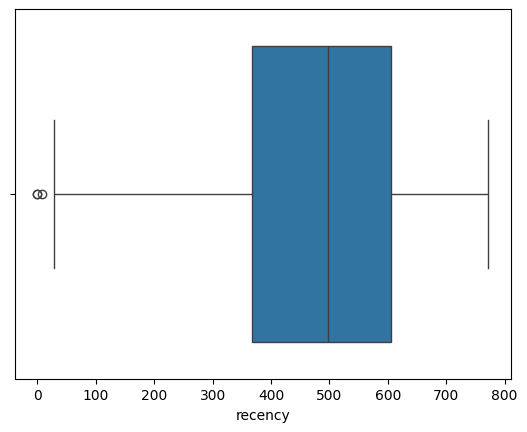

frequency: 


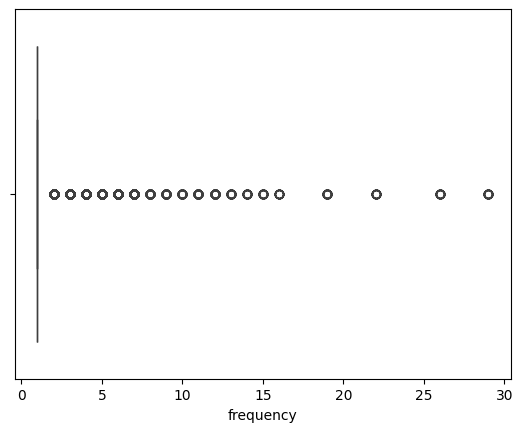

monetary_value: 


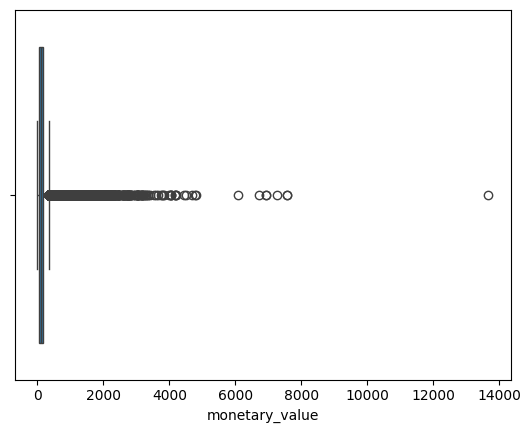

In [87]:
list1 = ['recency','frequency','monetary_value']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=final_rfm_df[str(i)])
    plt.show()

In [88]:
finaldf = final_rfm_df.copy()
# remove the customer id column
new_df = finaldf[['recency','frequency','monetary_value']]
# remove outliers
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_entries]   #remove all where z-score > 3
print(new_df.shape)
new_df.head()

(98100, 3)


,recency,frequency,monetary_value
0,612,1,141.90
1,609,1,27.19
2,186,1,86.22
3,402,1,43.62
4,435,1,196.89


In [89]:
new_df = new_df.drop_duplicates()

col_names = ['recency', 'frequency', 'monetary_value']
features = new_df[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features_df = pd.DataFrame(features, columns = col_names)

scaled_features_df.head()

,recency,frequency,monetary_value
0,0.847939,-0.180684,-0.010583
1,0.828533,-0.180684,-0.924001
2,-1.907653,-0.180684,-0.453954
3,-0.510452,-0.180684,-0.793171
4,-0.296990,-0.180684,0.427293


Text(0, 0.5, 'Inertia')

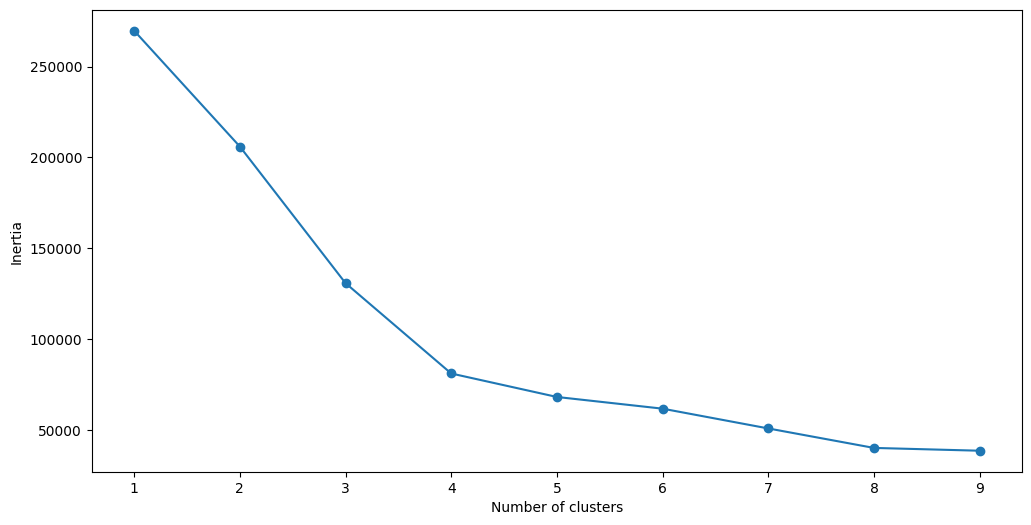

In [90]:
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(scaled_features_df)
    SSE.append(kmeans.inertia_)

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})

plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [91]:
silhoutte_score_dict = {}
for k in range(3, 6):
    kmeans = KMeans(n_clusters=k,init='k-means++', random_state=42)
    labels = kmeans.fit_predict(scaled_features_df)
    score = silhouette_score(scaled_features_df, labels)
    print(f'Clusters: {k}, Silhouette Score: {score :.3f}')
    silhoutte_score_dict[k] = score

Clusters: 3, Silhouette Score: 0.403
Clusters: 4, Silhouette Score: 0.450
Clusters: 5, Silhouette Score: 0.410


In [92]:
# build a model with 4 clusters
k = max(silhoutte_score_dict, key=silhoutte_score_dict.get)
print(f"Training the model with {k} clusters and Silhouette Score {silhoutte_score_dict[k]:.3f}\n")

model = KMeans(n_clusters = k, init='k-means++', n_init=10)
model.fit(scaled_features_df)

Training the model with 4 clusters and Silhouette Score 0.450



KMeans(n_clusters=4, n_init=10)

In [93]:
pred = model.predict(scaled_features_df)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred

In [94]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()
avg_df

,cluster,recency,frequency,monetary_value
0,0,593.395928,1.000000,110.392094
1,1,327.759037,1.000000,110.147489
2,2,486.860867,1.001682,448.855693
3,3,452.268098,2.161043,154.454807


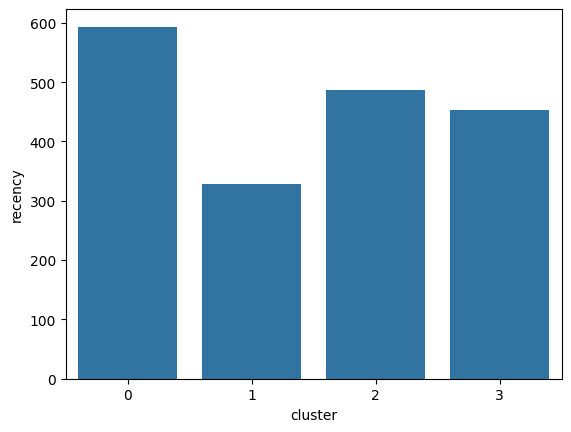

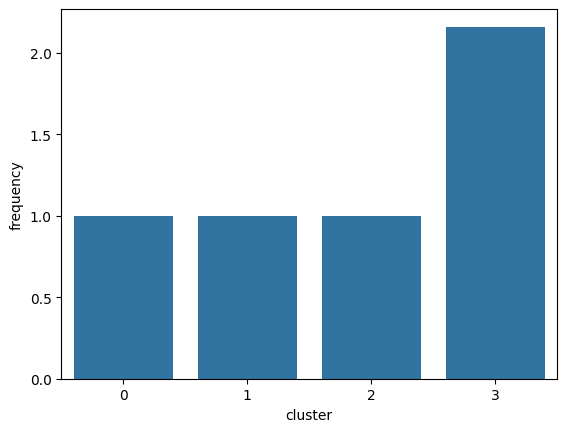

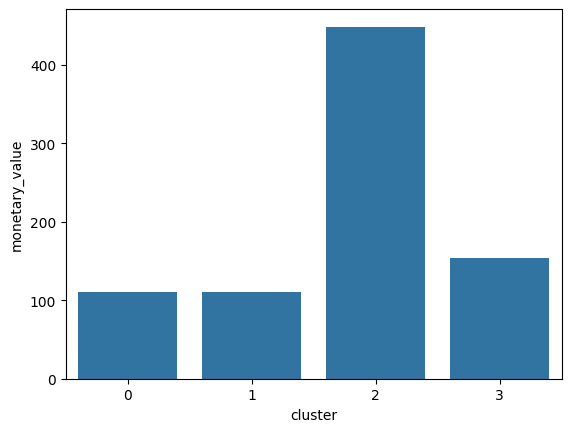

In [95]:
for i in list1:
    sns.barplot(x='cluster',y=str(i),data=avg_df)
    plt.show()

In [96]:
customer_with_cluster = pd.merge(final_rfm_df, frame[['cluster']], left_index=True, right_index=True)

print(customer_with_cluster.shape, frame.shape)

(89917, 5) (89917, 4)


In [97]:
# average metrics for each cluster
cluster_summary = frame.groupby('cluster').agg(
    customer_count=('cluster', 'count'),
    avg_recency=('recency', 'mean'),
    avg_purchase_frequency=('frequency', 'mean'),
    avg_monetary_value=('monetary_value', 'mean')
).reset_index()

segment_labels = {
    0: 'Most Recent, Avg Purchase Frequency, Low Monetary Value Customers',
    1: 'Least Recent, Avg Purchase Frequency, Low Monetary Value Customers',
    2: 'Recent, High Purchase Frequency, Low Monetary Value Customers',
    3: 'Recent, Avg Purchase Frequency, High Monetary Value Customers'
}
cluster_summary['segment_label'] = cluster_summary['cluster'].map(segment_labels)
cluster_summary.head(10)

,cluster,customer_count,avg_recency,avg_purchase_frequency,avg_monetary_value,segment_label
0,0,45329,593.395928,1.000000,110.392094,"Most Recent, Avg Purchase Frequency, Low Monetary Value Customers"
1,1,33005,327.759037,1.000000,110.147489,"Least Recent, Avg Purchase Frequency, Low Monetary Value Customers"
2,2,8323,486.860867,1.001682,448.855693,"Recent, High Purchase Frequency, Low Monetary Value Customers"
3,3,3260,452.268098,2.161043,154.454807,"Recent, Avg Purchase Frequency, High Monetary Value Customers"


In [98]:
customer_count_per_cluster = pd.DataFrame(frame['cluster'].value_counts()).rename(columns={'count': 'customer_count'})
customer_count_per_cluster = customer_count_per_cluster.sort_index()

# Add segment label description to the dataframe
customer_count_per_cluster['segment_label'] = customer_count_per_cluster.index.map(segment_labels)

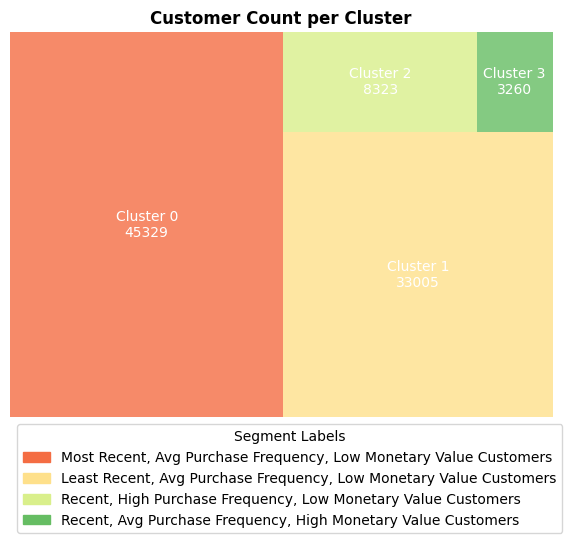

In [99]:
# Treemap configuration
plt.figure(figsize=(7, 5))  # Adjust the figure size
colors = sns.color_palette("RdYlGn", len(customer_count_per_cluster))

# Generate the treemap with segment descriptions
squarify.plot(
    sizes=customer_count_per_cluster['customer_count'],
    label=[
        f"Cluster {i}\n{count}" for i, count, label in zip(customer_count_per_cluster.index, customer_count_per_cluster['customer_count'], customer_count_per_cluster['segment_label'])
    ],
    color=colors[:len(customer_count_per_cluster)],
    text_kwargs={'fontsize': 10, 'color': 'white'},
    alpha=0.8
)

# Add title and remove axes
plt.title('Customer Count per Cluster', fontsize=12, fontweight='bold')
plt.axis('off')  # Hide the axes for a clean look

# Create custom legend
handles = [Patch(color=color, label=segment_labels[i]) for i, color in enumerate(colors[:len(customer_count_per_cluster)])]
plt.legend(handles=handles, loc='upper left', fontsize=10, title="Segment Labels", bbox_to_anchor=(0, 0))

plt.show()

<p align='center'>*** End Of The Notebook ***</p>